# Script Description

Download all necessary auxillary data from google earth engine:
- Corine 100m Landcover Data (only forest classes 311,312,313), rescaled to 500 meter resoution as tifs
    - 311 = Broadleaf
    - 312 = Coniferous
    - 313 = Mixed
- German border polygon as shapefile
- one timestep of the sif-variable from the ESDC, saved as a tif
    - used as a reference for resampling the corine data in the preprocessing

# Packages

In [1]:
from config import VARIABLES

In [2]:
import rasterio
import rioxarray as rio
import numpy as np
import matplotlib.pyplot as plt
from xcube.core.store import new_data_store
import matplotlib.pyplot as plt
import os
import geopandas as gpd

import rasterio
import numpy as np
import rasterio
from rasterio.windows import Window

# Initialize GEE

In [3]:

# Load Packages and initalize GEE

import ee
import geemap
ee.Authenticate(force=False)
ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com', project='ee-forest-health')


# 1. German border data

In [4]:

# Define a FeatureCollection for Germany using the FAO GAUL dataset, filtered for Germany's administrative level 0 (country level)
germany = ee.FeatureCollection('FAO/GAUL/2015/level0').filter(ee.Filter.eq('ADM0_NAME', 'Germany'))

# create geometry object (needed for giving a region when downloading the corine data)
germany_geometry = germany.geometry()

In [5]:
download = False
germany_shp_path = os.path.join('data', 'germany_border.shp')

if download:
        # Export the FeatureCollection to a shapefile
        geemap.ee_export_vector(germany, filename=germany_shp_path)

In [6]:
germany_gpd = gpd.read_file(germany_shp_path)

# 2. Load Corine Data

In [7]:
# define function to get the landcover data
def download_preprocess_corine(landcover_collection, year,path, region):
    
    landcover_year = landcover_collection.filterDate(str(year-1)+'-01-01', str(year)+'-12-31').first()

    zones=ee.Image(0) \
   .where(landcover_year.eq(311), 311) \
   .where(landcover_year.eq(312), 312) \
   .where(landcover_year.eq(313), 313) 
    
    geemap.ee_export_image(zones, 
                           filename = path, crs ="EPSG:4326", 
                           scale = 500, region = region)
    

    

In [8]:
landcover_collection = ee.ImageCollection('COPERNICUS/CORINE/V20/100m')

download = False

corine_file_paths = {}
years = [2000,2006,2012,2018]
for year in years:
    
    print("\n" ,100*"-", "\n")
    print(year)
    
    # path for year
    path = os.path.join("data", "landcover",f"forest_cover_{year}.tif")
    print(path)
    
    # append path to list
    corine_file_paths[year] = path
    
    # if download true then load data to path
    if download:
        print("Downloading data for year:", year)
        file_path_corine_cropped = download_preprocess_corine(landcover_collection, year, path=path, region=germany_geometry)



 ---------------------------------------------------------------------------------------------------- 

2000
data/landcover/forest_cover_2000.tif

 ---------------------------------------------------------------------------------------------------- 

2006
data/landcover/forest_cover_2006.tif

 ---------------------------------------------------------------------------------------------------- 

2012
data/landcover/forest_cover_2012.tif

 ---------------------------------------------------------------------------------------------------- 

2018
data/landcover/forest_cover_2018.tif


# 3. Load and preprocess ESDS Cube

Load and subset

In [9]:
# Initalize xcube store
store = new_data_store("s3", root="deep-esdl-public", storage_options=dict(anon=True))
store.list_data_ids()

# Load cube from store
cube = store.open_data( 'esdc-8d-0.25deg-256x128x128-3.0.1.zarr')

# Define the time and spatial subset
min_time = '2002-01-01'
max_time = '2021-12-31'
lon_min, lon_max = 5.866, 15.042
lat_min, lat_max = 47.270, 55.058

# Subset the cube
cube_subset = cube.sel(time=slice(min_time, max_time)) \
                  .sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))

# select only specified variables from esdc
cube_subset = cube_subset[VARIABLES]

# Add crs to the cube
cube_subset.rio.write_crs(4326, inplace = True)

<xarray.Dataset> Size: 30MB
Dimensions:                 (time: 920, lat: 31, lon: 37)
Coordinates:
  * lat                     (lat) float64 248B 47.38 47.62 47.88 ... 54.62 54.88
  * lon                     (lon) float64 296B 5.875 6.125 6.375 ... 14.62 14.88
  * time                    (time) datetime64[ns] 7kB 2002-01-05 ... 2021-12-31
    spatial_ref             int64 8B 0
Data variables:
    sif_gosif               (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    evaporation_era5        (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    precipitation_era5      (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    radiation_era5          (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    air_temperature_2m      (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    max_air_temperature_2m  (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
    min_air_temperature_2m  (time, lat, lon) float32 4MB dask.array<chunksize=(222, 31, 25), meta=np.ndarray>
Attributes: (12/23)
    Conventions:                CF-1.9
    acknowledgment:             All ESDC data providers are acknowledged insi...
    contributor_name:           ['University of Leipzig', 'Max Planck Institu...
    contributor_url:            ['https://www.uni-leipzig.de/', 'https://www....
    creator_name:               ['University of Leipzig', 'Brockmann Consult ...
    creator_url:                ['https://www.uni-leipzig.de/', 'https://www....
    ...                         ...
    publisher_url:              https://www.earthsystemdatalab.net/
    time_coverage_end:          2021-12-31T00:00:00.000000000
    time_coverage_start:        1979-01-05T00:00:00.000000000
    time_period:                8D
    time_period_reported_day:   5.0
    title:                      Earth System Data Cube (ESDC) v3.0.1

Create Subset raster tif

In [11]:
sample_path = os.path.join("data", "cube_sif_sample.tif")
cube_sif_sample = cube_subset["sif_gosif"].isel(time=0)
cube_sif_sample.rio.to_raster(sample_path)

Crop to germany border

In [12]:
# Clip the xarray dataset using the shapefile geometry
all_touched = True
cube_subset_crop = cube_subset.rio.clip(germany_gpd.geometry.values,germany_gpd.crs,
                                        drop = False, all_touched = all_touched)

# Resample corine data to SIF and create forest mask

In [13]:
# Open the landcover raster
with rasterio.open(corine_file_paths[2000]) as src_lc:
    lc_data = src_lc.read()
    lc_transform = src_lc.transform
    lc_crs = src_lc.crs
    lc_meta = src_lc.meta

# Open the sif raster
with rasterio.open(sample_path) as src_sif:
    sif_transform = src_sif.transform
    sif_meta = src_sif.meta
    sif_crs = src_sif.crs


In [15]:

# Determine the new shape and transform for the resampled raster
new_height = sif_meta['height']
new_width = sif_meta['width']
new_transform = sif_transform


# Initialize the new resampled data array
resampled_forest_percentage = np.zeros((new_height, new_width), dtype=np.float32)

# Define forest classes
forest_classes = [311, 312, 313]



# Calculate the window size in the original landcover data
window_height = int(abs(sif_transform[4] / lc_transform[4]))
window_width = int(abs(sif_transform[0] / lc_transform[0]))



In [16]:

def calculate_forest_percentage(lc_window, lc_data, forest_classes):

    forest_mask = np.isin(lc_data[lc_window.row_off:lc_window.row_off + lc_window.height,
                                  lc_window.col_off:lc_window.col_off + lc_window.width],
                          forest_classes)

    total_pixels = forest_mask.size
    forest_pixels = np.sum(forest_mask)
    percentage = (forest_pixels / total_pixels) * 100

    return percentage

In [17]:
# Loop through each cell in the sif raster resolution
for i in range(new_height):
    for j in range(new_width):
        # Define the window in the landcover data
        window = Window(col_off=j*window_width, row_off=i*window_height, width=window_width, height=window_height)
        
        # Calculate the forest percentage in the window
        forest_percentage = calculate_forest_percentage(window, lc_data.squeeze(), forest_classes)
        
        # Assign the percentage to the resampled data array
        resampled_forest_percentage[i, j] = forest_percentage


In [19]:
resampled_forest_percentage.shape

(31, 37)

# Plot

In [47]:
forest_mask = np.isin(lc_data, [311, 312, 313]).astype(int).squeeze()

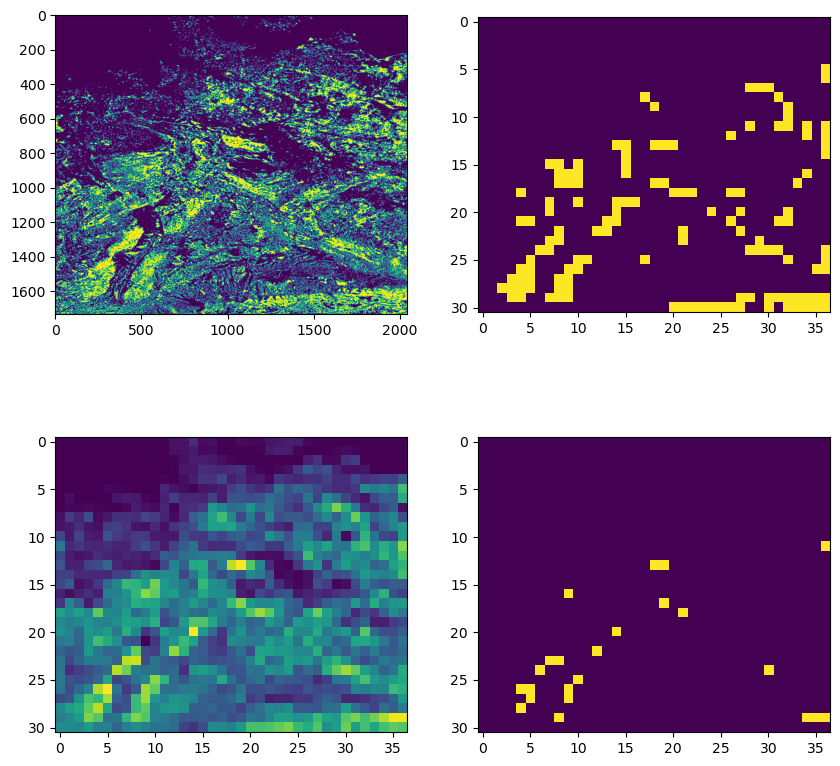

In [48]:
fig, axs = plt.subplots(2,2)
axs[0,0].imshow(forest_mask.squeeze())
axs[0,1].imshow(np.where(resampled_forest_percentage>=50,1,0).squeeze())
axs[1,0].imshow(resampled_forest_percentage.squeeze())
axs[1,1].imshow(np.where(resampled_forest_percentage>=70,1,0).squeeze())
fig.set_size_inches(10,10)

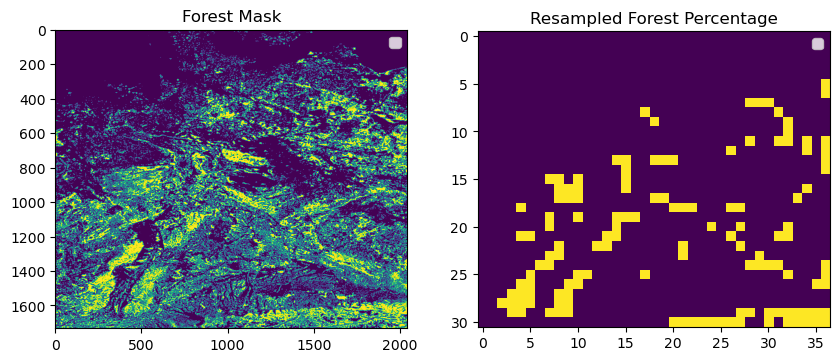

In [49]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(forest_mask)
axs[0].set_title('Forest Mask')
axs[0].legend(['Forest Mask'], loc='upper right')
axs[1].imshow(np.where(resampled_forest_percentage>=50,1,0))
axs[1].set_title('Resampled Forest Percentage')
axs[1].legend(['>= 50% Forest'], loc='upper right')
fig.set_size_inches(10,10)

# 4. Testing and Ploting

In [ ]:
import rioxarray as rio

[  0 311 312 313]
[  0 311 312 313]
[  0 311 312 313]
[  0 311 312 313]


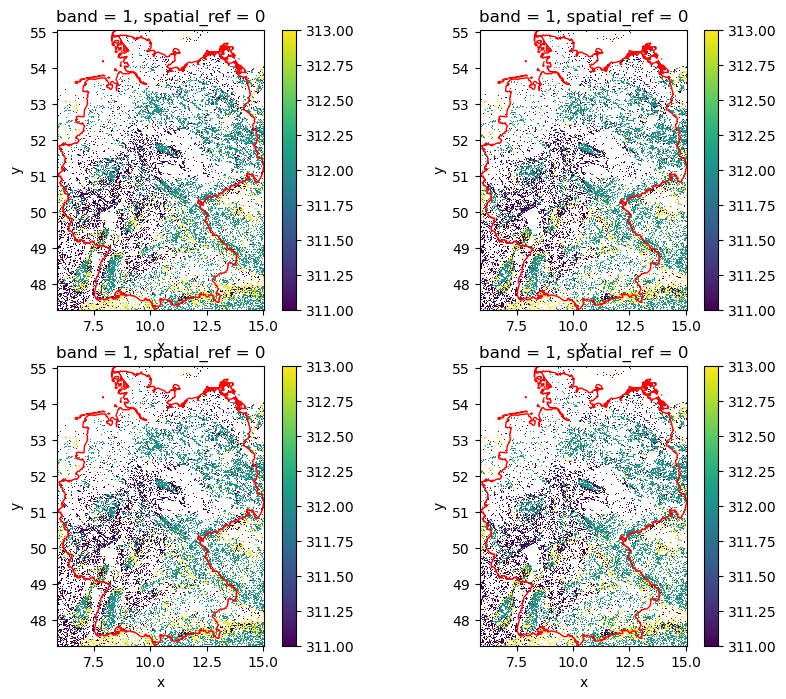

In [ ]:
fig, axs = plt.subplots(2,2, figsize = (10,8)) 

for i, year in enumerate(years):

    lc_year_path = corine_file_paths[i]
    lc_year = rio.open_rasterio(lc_year_path)

    print(np.unique(lc_year.values))

    # Mask out values of 0
    masked_data = lc_2012.where(lc_2012 != 0)

    # Plot the masked raster data in the appropriate subplot
    row_idx = i // 2  # Determines the row by dividing i by 2
    col_idx = i % 2   # Determines the column by the remainder of i divided by 2

    masked_data.plot(ax=axs[row_idx, col_idx], vmax=313, vmin=311)
    
    # Assuming germany_gpd is a GeoDataFrame, plot it on the same axes
    germany_gpd.plot(ax=axs[row_idx, col_idx], edgecolor='red', facecolor='none')

plt.show()

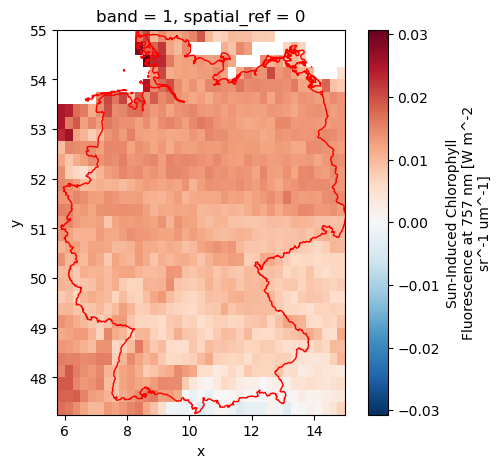

In [ ]:
cube_sample = rio.open_rasterio(sample_path)
fig, ax = plt.subplots(figsize = (6,5)) 
cube_sample.plot(ax=ax)
germany_gpd.plot(ax=ax, edgecolor='red', facecolor='none')
plt.show()